enter number of layers101


C:\Users\prath\AppData\Local\Temp\ipykernel_28264\282332104.py:57: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(G,gamma[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_28264\282332104.py:58: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_mixer_operator_circuit(G,beta[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_28264\282332104.py:162: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(

for 1 entropy is 1.349874353804359
for 2 entropy is 1.8556240816550384
for 3 entropy is 1.8760206133301554
for 4 entropy is 2.1483595007549026
for 5 entropy is 2.2988487886549756
for 6 entropy is 2.3684290371873815
for 7 entropy is 2.4251170328190383
for 8 entropy is 2.498219626089802
for 9 entropy is 2.5585750342353473
for 10 entropy is 2.595144762910783
for 11 entropy is 2.6316681792306245
for 12 entropy is 2.652446726225289
for 13 entropy is 2.687363306376248
for 14 entropy is 2.72809611965446
for 15 entropy is 2.747962333723247
for 16 entropy is 2.729730676732739
for 17 entropy is 2.765775058630953
for 18 entropy is 2.814896411046052
for 19 entropy is 2.805166920187068
for 20 entropy is 2.816433770787412
for 21 entropy is 2.843089696997086
for 22 entropy is 2.8488851716681025
for 23 entropy is 2.857145571584113
for 24 entropy is 2.8693855453207213
for 25 entropy is 2.8800586646394373
for 26 entropy is 2.889176494409883
for 27 entropy is 2.904588440286633
for 28 entropy is 2.8806593

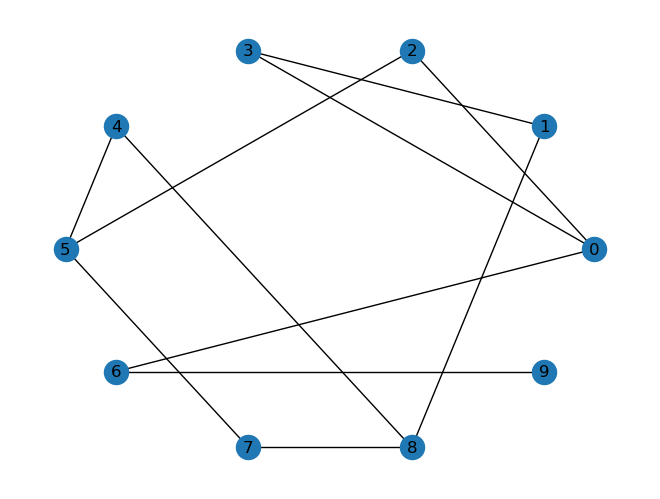

In [1]:
import qiskit
import random
import scipy.linalg
import math
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import *

m=int(input("enter number of layers"))
#initialise graph
seed=9999
G = nx.erdos_renyi_graph(10, 0.2, seed=seed)
pos = nx.circular_layout(G)
nx.draw(G, pos=pos, with_labels=True)

#cost operator
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc
qc = get_cost_operator_circuit(G, np.pi / 3)

#mixer operator
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc
qc = get_mixer_operator_circuit(G, np.pi/3)

#QAOA CIRCUIT
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])

#to fix qiskit qubit ordering
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()

#defining maxcut values and stuff
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

#the circuit put inside a blackbox
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

entropy=[]
layers=[]
entropy_data=[]
    
for p in range(1, m):
    
    entropy_data=[]
    for c in range(1, 101):
        #the optimisation part but randomised
        obj = get_black_box_objective(G, p)
    #random.seed(69)

        my_array = []

        for i in range(p):
            my_array.append(random.uniform(0, np.pi))

        for i in range(p):
            my_array.append(random.uniform(0, 2*np.pi))

    
        init_point = my_array
        res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':0, 'disp': True})
        optimal_theta = res_sample['x']
        qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
        counts = invert_counts(execute(qc, backend).result().get_counts())

    # for state vector formalism
        def state_num2str(basis_state_as_num, nqubits):
            return '{0:b}'.format(basis_state_as_num).zfill(nqubits)

        def state_str2num(basis_state_as_str):
            return int(basis_state_as_str, 2)

        def state_reverse(basis_state_as_num, nqubits):
            basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
            new_str = basis_state_as_str[::-1]
            return state_str2num(new_str)

        def get_adjusted_state(state):
            nqubits = np.log2(state.shape[0])
            if nqubits % 1:
                raise ValueError("Input vector is not a valid statevector for qubits.")
            nqubits = int(nqubits)

            adjusted_state = np.zeros(2**nqubits, dtype=complex)
            for basis_state in range(2**nqubits):
                adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
            return adjusted_state
    
        def get_qaoa_circuit_sv(G, beta, gamma):
            assert(len(beta) == len(gamma))
            p = len(beta) # infering number of QAOA steps from the parameters passed
            N = G.number_of_nodes()
            qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
            qc.h(range(N))
    # second, apply p alternating operators
            for i in range(p):
                qc += get_cost_operator_circuit(G,gamma[i])
                qc += get_mixer_operator_circuit(G,beta[i])
    # no measurement in the end!
            return qc

        def state_to_ampl_counts(vec, eps=1e-15):
            qubit_dims = np.log2(vec.shape[0])
            if qubit_dims % 1:
                raise ValueError("Input vector is not a valid statevector for qubits.")
            qubit_dims = int(qubit_dims)
            counts = {}
            str_format = '0{}b'.format(qubit_dims)
            for kk in range(vec.shape[0]):
                val = vec[kk]
                if val.real**2+val.imag**2 > eps:
                    counts[format(kk, str_format)] = val
            return counts

        backend = Aer.get_backend('statevector_simulator')
        qc = get_qaoa_circuit_sv(G, optimal_theta[:p], optimal_theta[p:])
        sv = get_adjusted_state(execute(qc, backend).result().get_statevector())
        matrix=state_to_ampl_counts(sv)
    
        values = np.array(list(matrix.values()))
        output = np.reshape(values, (-1, 32)) # reshape the array and extract the real part
        truematrix = output.T
        U, D, V = scipy.linalg.svd(truematrix)
        precision = 4
        singular = [round(num, precision) for num in D]
        total = 0
        for num in singular:
            if num != 0:
                total += (-1)*(num**2 * math.log(num**2))
        entropy_data.append(total)
    entropyavg = sum(entropy_data) / len(entropy_data)
    entropy.append(entropyavg)
    layers.append(p)
    print("for", p, "entropy is", entropyavg)
    
    

    
file_path1 = 'entropyrenyi10.csv'
with open(file_path1, mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in entropy:
        writer.writerow([value])

file_path2 = 'layersrenyi10.csv'
with open(file_path2, mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in layers:
        writer.writerow([value])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


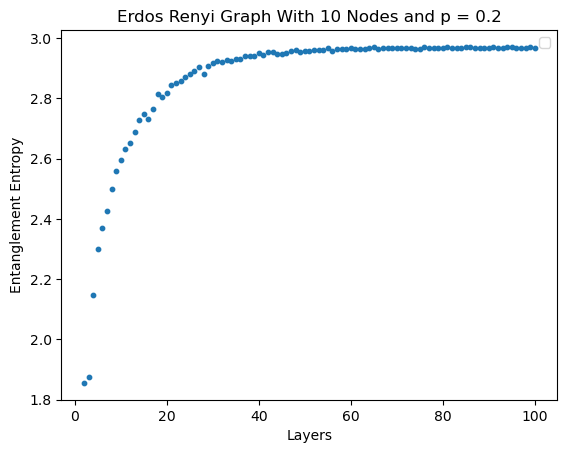

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
l = pd.read_csv('layersrenyi10.csv')
e = pd.read_csv('entropyrenyi10.csv')
plt.scatter(l,e, s=10)
plt.legend() 
plt.title("Erdos Renyi Graph With 10 Nodes and p = 0.2")
plt.xlabel("Layers")
plt.ylabel("Entanglement Entropy")
plt.show()

In [ ]:
# very crisp